# MovieLens Dataset Pre-Processing and Analysis

##### This python notebook is designed to pre-process and pre-analyze the data found in the MovieLens database.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime
from scipy import stats
import imdb
import os
from numpy import array
from scipy.linalg import svd
from sklearn.cluster import KMeans
import seaborn as sns
import operator
%matplotlib inline

#### Importing Data from CSVs
#### Editing Timestamps 
#### Printing Dataset Shape

In [19]:
links = pd.read_csv(r"../ml-latest-small/links.csv") #Links show Movie ID, IMDB ID, and TMDB ID
movies = pd.read_csv(r"../ml-latest-small/movies.csv") #Movies Show Movie ID, Title, Genres
ratings = pd.read_csv(r"../ml-latest-small/ratings.csv") #Ratings show userid, movieid, ratings, and timestamps (Can we apply a flocking algorithm?)
tags = pd.read_csv(r"../ml-latest-small/tags.csv") #User ID, Movie ID, Tag, and Timestamp
print(tags.shape)
tags.timestamp = tags.apply(lambda x : datetime.strptime(time.ctime(x.timestamp),"%a %b %d %H:%M:%S %Y"), axis = 1)
ratings.timestamp = ratings.apply(lambda x : datetime.strptime(time.ctime(x.timestamp),"%a %b %d %H:%M:%S %Y"), axis = 1)
print("links", links.shape) 
print("movies", movies.shape)
print("ratings", ratings.shape)
print("tags", tags.shape)

(3683, 4)
links (9742, 3)
movies (9742, 3)
ratings (100836, 4)
tags (3683, 4)


#### Printing Initial Data Information 

In [20]:
#Data Range Between 1996-2018
print("Min Time: ", min(ratings.timestamp))
print("Max Time: ", max(ratings.timestamp))
print("Number of users: ", ratings.userId.nunique())
print("Average # of Ratings per User: ", np.mean(list(ratings.userId.value_counts())))
print("Median # of Ratings per User: ", np.median(list(ratings.userId.value_counts())))
print("Average Ratings per Movie: ", ratings.groupby(by = "movieId", axis = 0).sum().rating.mean())
print("Median # of Ratings per Movie", ratings.groupby(by = "movieId", axis = 0).sum().rating.median())
print("rating min: ", min(ratings.rating))
print("rating max: ", max(ratings.rating))
print("Unique Rating Possibilities: ", ratings.rating.unique())

Min Time:  1996-03-30 02:36:55
Max Time:  2018-09-24 22:27:30
Number of users:  610
Average # of Ratings per User:  165.30491803278687
Median # of Ratings per User:  70.5
Average Ratings per Movie:  36.310468942821885
Median # of Ratings per Movie 8.5
rating min:  0.5
rating max:  5.0
Unique Rating Possibilities:  [4.  5.  3.  2.  1.  4.5 3.5 2.5 0.5 1.5]


#### Calculating Standard Deviations to Identify Outliers which may Skew Data

Inner-Quantile Range 133.0
Standard Deviation of Ratings Count:  269.2596080610495
Outliers (Right)  438.5
Outliers (Left)  102.5




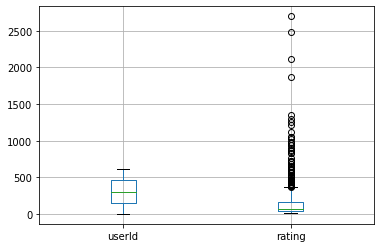

In [21]:
std_dev = pd.DataFrame(ratings.groupby(by = "userId", axis = 0).count().rating)
std_dev = std_dev.reset_index()
st_dev = np.std(std_dev.rating)
print("Inner-Quantile Range", std_dev.quantile(.75)[1] - std_dev.quantile(.25)[1])
print("Standard Deviation of Ratings Count: ", st_dev)
print("Outliers (Right) ", std_dev.quantile(.5)[0] + std_dev.quantile(.75)[1] - std_dev.quantile(.25)[1])
print("Outliers (Left) ", std_dev.quantile(.5)[0] - std_dev.quantile(.75)[1] - std_dev.quantile(.25)[1])
print("\n")
std_dev.boxplot()

#### Attributes of Data for Tags

In [22]:
print("Min Time:", tags.timestamp.min())
print("Max Time:", tags.timestamp.max())
print("number of users", tags.userId.nunique())
print("Average Number of Tags per Movie:", tags.groupby(by = "movieId", axis = 0).count().tag.mean())
print("Median Number of Tags per Movie:", tags.groupby(by = "movieId", axis = 0).count().tag.median()) #Median Tag Number is 1

print("Number of Unique Tags: ", tags.tag.nunique())
print("Number of Unique Users: ", tags.userId.nunique())
print("Number of Unique Movies: ", tags.movieId.nunique())
print("Number of Tags: ", tags.shape[0])

Min Time: 2006-01-14 03:09:12
Max Time: 2018-09-16 19:50:03
number of users 58
Average Number of Tags per Movie: 2.3428753180661577
Median Number of Tags per Movie: 1.0
Number of Unique Tags:  1589
Number of Unique Users:  58
Number of Unique Movies:  1572
Number of Tags:  3683


## Section: Analyze the Most Frequent Genres in the Movie Set

In [23]:
#Getting unique genres and unique tags
import collections
genre_dict = {}
for entry in movies.genres:
    temp = entry.split('|')
    for j in temp:
        try:
            genre_dict[j] += 1
        except:
            genre_dict[j] = 1
            
genre_dict = collections.OrderedDict(sorted(genre_dict.items(), key=lambda x:x[1]))
print(genre_dict.values())
print(genre_dict.keys())

odict_values([34, 87, 158, 167, 334, 382, 440, 573, 611, 664, 779, 978, 980, 1199, 1263, 1596, 1828, 1894, 3756, 4361])
odict_keys(['(no genres listed)', 'Film-Noir', 'IMAX', 'Western', 'Musical', 'War', 'Documentary', 'Mystery', 'Animation', 'Children', 'Fantasy', 'Horror', 'Sci-Fi', 'Crime', 'Adventure', 'Romance', 'Action', 'Thriller', 'Comedy', 'Drama'])


Length: 20


(-1.101904743349182,
 1.1163828500180555,
 -1.1024517392200537,
 1.1001167576325557)

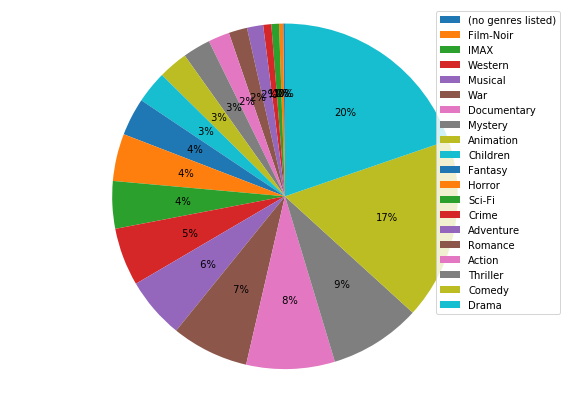

In [24]:
print("Length:", len(genre_dict))
plt.figure(figsize=(10,7))
patches, texts, autotext = plt.pie(genre_dict.values(),  autopct='%2.0f%%', startangle=90)
plt.legend(patches, genre_dict.keys(), loc="best")
# plt.tight_layout()
plt.axis('equal')

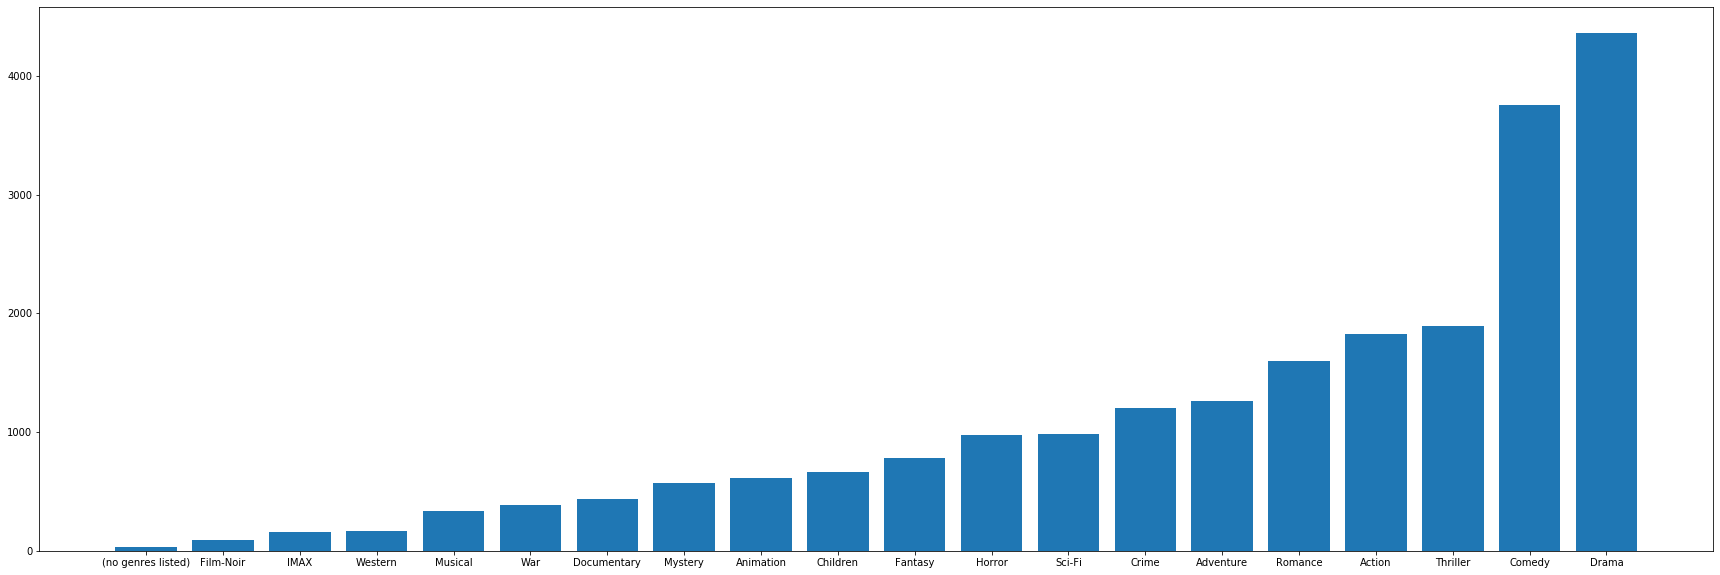

In [25]:
plt.figure(figsize=(30,10))
plt.bar(range(len(genre_dict)), list(genre_dict.values()), align='center')
plt.xticks(range(len(genre_dict)), list(genre_dict.keys()))
plt.show()

## Performing Initial SVD/PCA Analysis

The purpose here is to understand the dimensionality of the dataset, specifically on which factors (and how many) contribute to a significant portion of the information concerning users viewing habits

The first step concerns creating a ratings matrix, which pivots the ratings matrix on user_Id (index) and movie_Id (columns), such that each column represents a movie and each index a user (cross-section indicating user ratings for a specific movie)

It is imortant to normalize the resulting numpy array, before creating the correlation matrix to be used in SVD (AAT and ATA Matrices) which will extract the movie and user "concepts" from the dataset

In [26]:
rating_matrix = ratings.pivot(index = "userId", columns = "movieId", values = "rating")
rating_matrix = rating_matrix.fillna(0)
nparray = rating_matrix.to_numpy()
nparray_norm = (nparray - np.mean(nparray)) / np.std(nparray)

##### We use numpy's SVD package to perform the Singular Value Decomposition

In [27]:
s, v, d = np.linalg.svd(nparray_norm, compute_uv = True)

In [28]:
print("Shape of the S, V, and D, Matrices: ", s.shape, v.shape, d.shape)

#Find users whose "concepts" correspond to the largest eigen vector
index_of_top = []
for i in range(len(s)):
    index = np.where(s[i] == np.amax(s[i]))[0][0]
    if index == 0:
        index_of_top += [i]
print("No User actual correspons to the maximum eigen vector: ", index_of_top)

Shape of the S, V, and D, Matrices:  (610, 610) (610,) (9724, 9724)
No User actual correspons to the maximum eigen vector:  []


This first round of SVD is not particularly successful, as there are plenty of outliers currently in the dataset

We also reverse engineer the matrices to test whether Numpy's Linear Algebra Function Correctly calculated SVD

In [29]:
#Testing if numpy correctly performs SVD (it does)
#Applying result to original array
#This should be the covariance matrix PCA for users (610 users represented by 2 attributes)
pca_mat_user = np.dot(np.dot(nparray_norm,nparray_norm.T), s[:,:2])
pca_mat_mov = np.dot(np.dot(nparray_norm.T, nparray_norm),d[:,:2])
pca_mat_user_test = np.dot(s[:,:2],np.diag(v)[:2,:2]**2)
pca_mat_mov_test = np.dot(d[:,:2],np.diag(v)[:2,:2]**2)

Because SVD is simply a deeper breakdown of both correlation matrices (Users and Movies), we are able to back out PCA by multipylying the eigen vector matrix (S) against the correlation matrix of the user-movie pivoted table

Based on the plots, we see that both PCA matrices perform identically

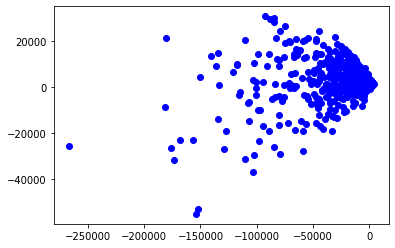

In [30]:
#Plotting PCA
#COlor by most watched film genre
plt.plot(pca_mat_user[:,0], pca_mat_user[:,1], "bo")
#Test with plt.plot(pca_mat_user_test[:,0], pca_mat_user_test[:,1], "bo")

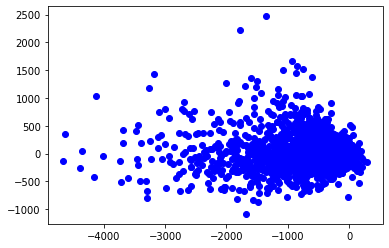

In [31]:
plt.plot(pca_mat_mov[:,0], pca_mat_mov[:,1], "bo")

### In the next section, we demonstrate the viability of linking to the imdb and tmdb databases

In [32]:
ia = imdb.IMDb()
movies_updated = movies.join(links, rsuffix="links")
movies_updated = movies_updated.drop('movieIdlinks', axis = 1)

In [33]:
#Testing API
ia.get_movie_infoset() #Provides the attributes of movies
toy_story = ia.get_movie(114709, info = ['keywords'])

Building Genere Dataframe for further analysis. Simply expanding dataframe to represent unique row for each movie genre

In [35]:
genre_df = (movies.set_index(['movieId','title']).apply(lambda x : x.str.split('|').explode()).reset_index())

### In this next section, we re-perform our initial SVD/PCA analysis. This time, we use cleaner data, to see if we can extract the correct number of "clusters" for further k-means analysis that will contribute to our recommendation system

In [36]:
iqr = std_dev.quantile(.50)[1] + std_dev.quantile(.75)[1] - std_dev.quantile(.25)[1]
ratings_merge = pd.merge(std_dev, ratings, on = "userId")
ratings_cleaned = ratings_merge[ratings_merge["rating_x"] < iqr]
rating_matrix = ratings_cleaned.pivot(index = "userId", columns = "movieId", values = "rating_y")
rating_matrix = rating_matrix.fillna(0)
nparray = rating_matrix.to_numpy()
nparray_norm = (nparray - np.mean(nparray)) / np.std(nparray)
print("Count of Users Removed: ", std_dev.shape[0] - nparray_norm.shape[0])

Count of Users Removed:  130


In [37]:
s, v, d = np.linalg.svd(nparray_norm, compute_uv = True)

In [38]:
pca_mat_user_clean = np.dot(s[:,:2],np.diag(v)[:2,:2]**2)
pca_mat_mov_clean = np.dot(d[:,:2],np.diag(v)[:2,:2]**2)

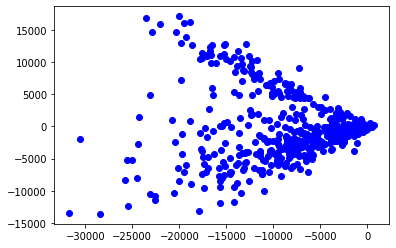

In [39]:
plt.plot(pca_mat_user_clean[:,0], pca_mat_user_clean[:,1], "bo")

It's clear that we are able to capture more variance in these dimensions, however, the data set is still pretty noisy. We print the eigen value diagonal matrix and see that the values are relatively high in the range of 0-20, indicating a large amount of groups & clusters.

In [40]:
print(v[:20])

[486.01993857 344.98568283 240.71480428 213.01459306 179.73745866
 173.1291618  164.30249466 155.04246451 148.39840267 139.08300493
 137.10248579 131.19550595 130.67282487 125.68792711 125.02823627
 124.48683309 122.72579462 119.45922892 119.18343594 118.03929969]


### We run K-means to cluster the data using sklearns KMeans package. We the plot the PCA coordinates and color them by the Kmeans clusters.

In [80]:
kmeans = KMeans(7, init = "k-means++", n_init=10, max_iter = 300)
pred_y = kmeans.fit_predict(nparray_norm)

In [81]:
pca_df = pd.DataFrame(pca_mat_user_clean)
pca_df.columns = ["x", "y"]
pca_df['userId'] = rating_matrix.index
pca_df['predicted'] = pred_y

In [82]:
export_kmeans = pd.merge(pca_df, ratings_cleaned, on = "userId")
export_kmeans = pd.merge(export_kmeans, movies, on = "movieId")
export_kmeans = export_kmeans.drop(["x","y","timestamp"], axis = 1)
export_kmeans.columns = ['userId', 'cluster', 'num_ratings', 'movieId', 'rating', 'title', 'genres']


In [83]:
export_kmeans.to_csv("../csvData/exported_kmeans.csv")

In [91]:
export_kmeans[export_kmeans["userId"] == 607].genres.nunique()

106

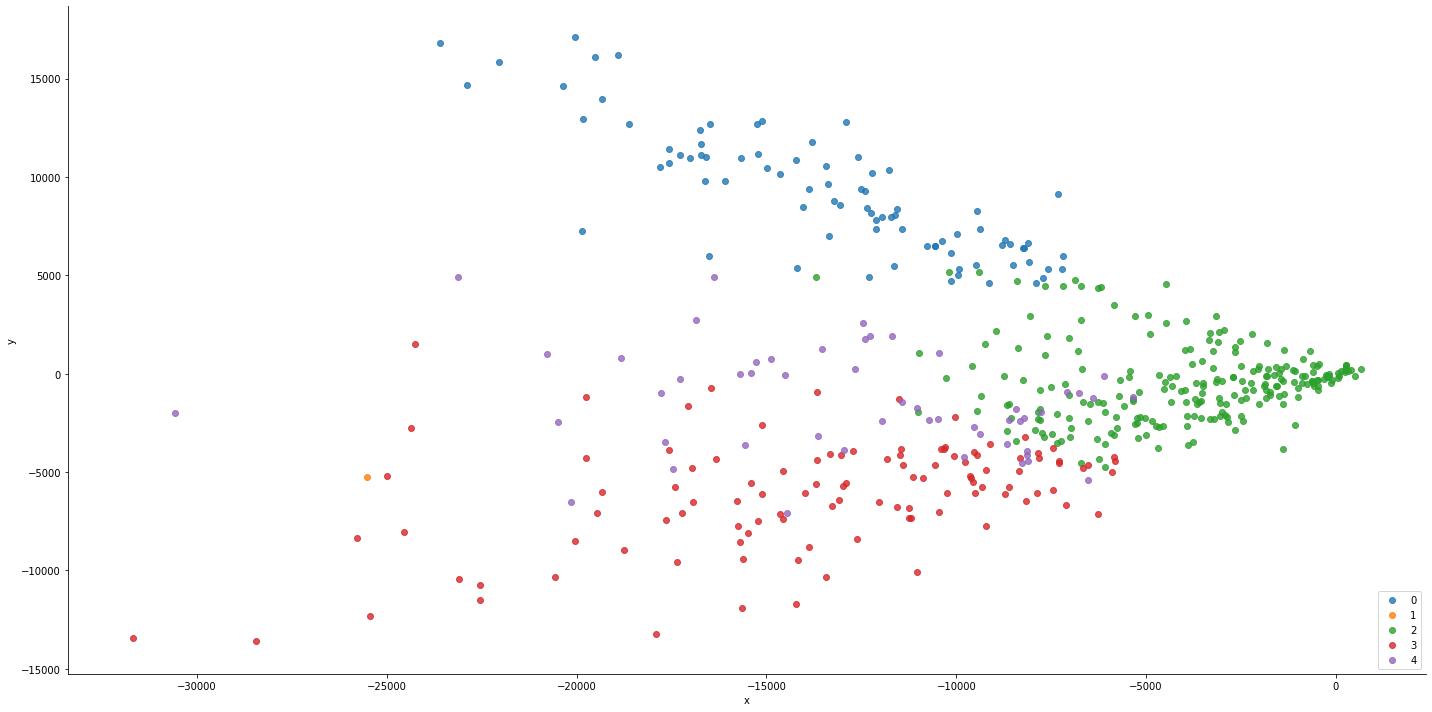

In [79]:
sns.lmplot( x="x", y="y", data = pca_df, fit_reg=False, hue="predicted", height = 10, aspect = 2, legend=False)
plt.legend(loc='lower right')

In [ ]:
#Exporting K-means Clusters


We also proceed with a simple analysis of the most watched user genres (which we simply classify as those genres corresponding to movies that the User has rated (e.g.) It is clear from this analysis that we may get more from interpreting K-means outcomes, as this next analysis does not take into account how much the user liked the films, whereas K-means clustering does. 

In [108]:
#Getting the top most watched genres for each user
user_genres = pd.merge(ratings_cleaned, genre_df, on="movieId")

Here we get the most populare genres for each user

In [128]:
user_genre_dict ={}
for index, row in user_genres.iterrows():
    try:
        user_genre_dict[row['userId']]
    except:
        user_genre_dict[row['userId']] = {}
    try:
        user_genre_dict[row['userId']][row['genres']] += 1
    except:
        user_genre_dict[row['userId']][row['genres']] = 1

fav_genre = {}
for key in user_genre_dict:
    maximum = max(user_genre_dict[key].items(), key = operator.itemgetter(1))[0]
    fav_genre[key] = maximum
    
fav_genre = pd.DataFrame.from_dict(fav_genre, orient = "index")
fav_genre = fav_genre.reset_index()
fav_genre.columns = ['userId','FavGenre']
pca_df = pd.DataFrame(pca_mat_user_clean)
fav_genre.FavGenre.nunique()
fav_genre
pca_df.index = np.arange(1, len(pca_df) + 1)
pca_df = pd.DataFrame(pca_mat_user)
pca_df.index = np.arange(1, len(pca_df) + 1)
pca_df = pca_df.reset_index()
pca_df.columns = ['userId', 'factor_1', 'factor_2']

In [130]:
plot_df = pd.merge(pca_df, fav_genre, on = "userId")
plot_df_update = pd.merge(plot_df, std_dev, on = "userId")
plot_df_update["outlier"] = plot_df_update.apply(lambda x : x.rating > 203, axis = 1)

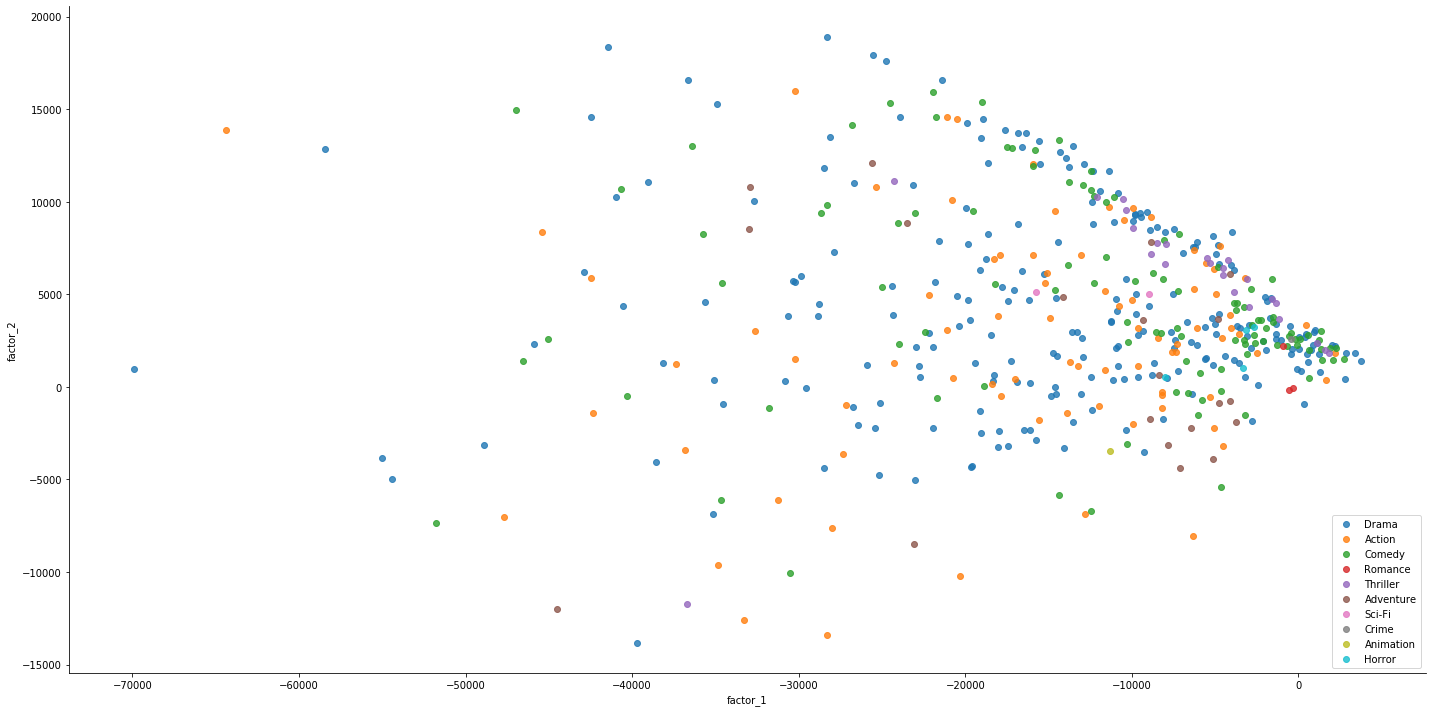

In [131]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="factor_1", y="factor_2", data=plot_df_update, fit_reg=False, hue='FavGenre', height = 10, aspect = 2, legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')


We can see from the visualization above that the genres do not, at least per our current analysis, correspond to our clustering.

We also signed up for a TMDb api key, in case we needed to scrape more data. Eventually, we settled on pulling in industry data from box office mojo.

In [ ]:
# from tmdbv3api import TMDb
# tmdb = TMDb()
# tmdb.api_key = 'bbf25fae7203def03e17f79789d653c6'
# from tmdbv3api import Movie
# movie = Movie()

### Webscrapping with Selenium and BeutifulSoup to get revenue, rank, and release data on the top grossing films from the years 1989 - 2019. 

In [278]:
from bs4 import BeautifulSoup
import bs4
from selenium import webdriver
import pandas as pd
import numpy as np
from selenium.webdriver.chrome.options import Options
from re import sub
from decimal import Decimal

In [364]:
url = "https://www.boxofficemojo.com/year/{}/".format(2012)

def create_driver():
    browser_options = Options()
    browser_options.add_argument("--headless")
    browser_options.add_argument('--no-sandbox')
    driver = webdriver.Chrome(chrome_options=browser_options)
    print("Done Creating Browser")
    return driver


def convdollar(x):
    if 'k' in x:
        return float(x.replace('k',''))*1000
    else:
        return float(x)*1000000
    
def scrape(box_office, start, finish):
    driver = create_driver()
    years=[str(a) for a in range(start,finish)]
    df_list=[]
    for year in years:
        url = "https://www.boxofficemojo.com/year/{}/".format(year) 
        driver.get(url)
        page_content = driver.page_source
        print('Box Office data for %s scraped' % year)
        p=BeautifulSoup(page_content)
        table = p.find_all("table")
        mov_dict = {}
#         value = Decimal(sub(r'[^\d.]', '', money))
        mov_dict["rank"] = [i.getText() for i in table[1].find_all("td", { "class" : "mojo-field-type-rank"})]
        mov_dict["year"] = [year for i in range(len(mov_dict["rank"]))]
        mov_dict["movie"] = [i.getText() for i in table[1].find_all("td", { "class" : "mojo-field-type-release"})]
        mov_dict["studio"] = [i.getText().replace("\n","") for i in table[1].find_all("td", { "class" : "mojo-field-type-studio"}) if i.getText() != None]
        mov_dict["gross"] = [Decimal(sub("[^0-9a-zA-Z]+","", j)) for j in [i.getText() for i in table[1].find_all("td", { "class" : "mojo-field-type-money"})][2::3]]
        mov_dict["release"] = [i.getText() for i in table[1].find_all("td", { "class" : "mojo-field-type-date"})]
        temp_frame = pd.DataFrame(mov_dict)
        box_office = box_office.append(temp_frame, ignore_index = True)
    driver.quit()
    return box_office


In [132]:
box_office = pd.DataFrame()
box_office = scrape(box_office, 1989, 2019)
cols = box_office.columns.tolist()
new_cols = cols[1:2] + cols[0:1] + cols[2:]
box_office = box_office[new_cols]

NameError: name 'scrape' is not defined

In [370]:
box_office.to_csv("Box_Office_Data_1989_2018.csv")